# Lab | QLoRA Tuning using PEFT from Hugging Face

<!-- ### Introduction to Quantization & Fine-tune a Quantized Model -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.

# Brief Introduction to Quantization
The main idea of quantization is simple: Reduce the precision of floating-point numbers, which normally occupy 32 bits, to integers of 8 or even 4 bits.

This reduction occurs in the model’s parameters, specifically in the weights of the neural layers, and in the activation values that flow through the model’s layers.

This means that we not only achieve an improvement in the model’s storage size and memory consumption but also greater agility in its calculations.

Naturally, there is a loss of precision, but particularly in the case of 8-bit quantization, this loss is minimal.



## Let's see a example of a quantized number.

In reality, what I want to examine is the precision loss that occurs when transitioning from a 32-bit number to a quantized 8/4-bit number and then returning to its original 32-bit value.

First, I'm going to create a function to quantize and another to unquantize.

In [1]:
#Importing necesary linbraries
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#Functions to quantize and unquantize
def quantize(value, bits=4):
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    return int(quantized_value)

def unquantize(quantized_value, bits=4):
    value = quantized_value / (2**(bits - 1) - 1)
    return float(value)

Quatizied values:

In [3]:
quant_4 = quantize(0.622, 4)
print (quant_4)
quant_8 = quantize(0.622, 8)
print(quant_8)

4
79


Unquantized values:

In [4]:
unquant_4 = unquantize(quant_4, 4)
print(unquant_4)
unquant_8 = unquantize(quant_8, 8)
print(unquant_8)

0.5714285714285714
0.6220472440944882


If we consider that the original number was 0.622, it can be said that 8-bit quantization barely loses precision, and the loss from 4-bit quantization is manageable.

In [5]:
x = np.linspace(-1, 1, 50)
y = [math.cos(val) for val in x]


y_quant_8bit = np.array([quantize(val, bits=8) for val in y])
y_unquant_8bit = np.array([unquantize(val, bits=8) for val in y_quant_8bit])

y_quant_4bit = np.array([quantize(val, bits=4) for val in y])
y_unquant_4bit = np.array([unquantize(val, bits=4) for val in y_quant_4bit])


Let’s plot a curve with the unquantized values of a cosine.


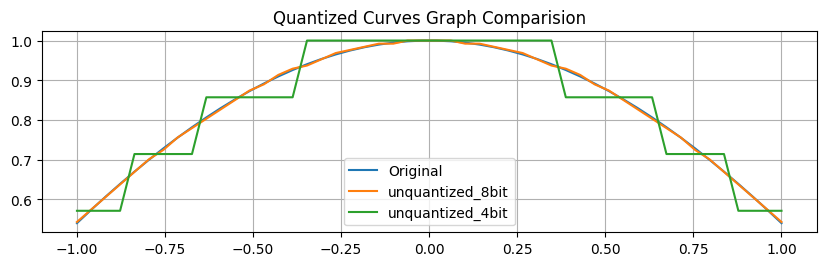

In [6]:
plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label="Original")
plt.plot(x, y_unquant_8bit, label="unquantized_8bit")
plt.plot(x, y_unquant_4bit, label="unquantized_4bit")
plt.legend()
plt.title("Quantized Curves Graph Comparision")
plt.grid(True)

As you can see, the difference between the 8-bit and the original values is minimal. However, we need to use 4-bit quantization if we want to load the 7B Model into a 16GB GPU without problems.


# QLoRA. Fine-tuning a 4-bit Quantized Model using LoRA.
We are going to fine-tune with LoRA a 7B Model Quantizated to 4 bits.

## Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

#### Check the librairies version before download or adjustments

In [8]:
import importlib

def check_version(lib_name):
    try:
        lib = importlib.import_module(lib_name)
        version = getattr(lib, '__version__', '❓ Version not found')
        print(f"{lib_name}: ✅ Installed, version {version}")
    except ImportError:
        print(f"{lib_name}: ❌ Not installed")


check_version("accelerate")
check_version("bitsandbytes")
check_version("trl")
check_version("peft")
check_version("transformers")
check_version("datasets")

accelerate: ✅ Installed, version 1.7.0
bitsandbytes: ❌ Not installed
trl: ❌ Not installed
peft: ✅ Installed, version 0.15.2
transformers: ✅ Installed, version 4.52.4
datasets: ✅ Installed, version 2.14.4


In [9]:
!pip install -q accelerate==0.29.3
!pip install -q bitsandbytes==0.43.1
!pip install -q trl==0.8.6
!pip install -q peft==0.10.0
!pip install -q transformers==4.40.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [26]:
!pip uninstall -y peft
!pip install git+https://github.com/huggingface/peft.git

Found existing installation: peft 0.15.2
Uninstalling peft-0.15.2:
  Successfully uninstalled peft-0.15.2
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-tw2_lxeo
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-tw2_lxeo
  Resolved https://github.com/huggingface/peft.git to commit cc38f09d1d4f048cf94ff0dbe3a9de810f563049
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peft: filename=peft-0.15.2.dev0-py3-none-any.whl size=440222 sha256=07ffd06a8e56c696a70c703f9d9da8b169f383089a1e29a99c4dc65efba38120
  Stored in directory: /tmp/pip-ephem-wheel-cache-sur5jpwc/wheels/42/ec/c4/eb24dac74be83ba2ed4817037a784d1c775e317cb8de69963f
Successfully built peft


I'm going to download the peft and Transformers libraries from their repositories on GitHub instead of using pip. This is not strictly necessary, but this way, you can get the newest versions of the libraries with support for newer models. If you want to check one of the latest models, you can use this trick.


In [ ]:
#Install the lastest versions of peft & transformers library recommended
#if you want to work with the most recent models
#!pip install -q git+https://github.com/huggingface/peft.git
#!pip install -q git+https://github.com/huggingface/transformers.git

From the Transformers library, we import the necessary classes to load the model and the tokenizer.

The notebook is ready to work with different Models I tested it with models from the Bloom Family and Llama-3.

I recommend you to test different models.

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

## Hugging Face login

## Load Model

In [8]:
#Use any model you want, if you want to do some fast test, just use the smallest one.

#model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
#model_name = "bigscience/bloom-7b1"
#target_modules = ["query_key_value"]

model_name = "bigscience/bloomz-560m"
target_modules = ["query_key_value"] #YOU MAY CHANGE THIS BASED ON YOUR MODEL

To load the model, we need a configuration class that specifies how we want the quantization to be performed. We’ll achieve this with the BitesAndBytesConfig from the Transformers library.

In [9]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

We are specifying the use of 4-bit quantization and also enabling double quantization to reduce the precision loss.

For the bnb_4bit_quant_type parameter, I've used the recommended value in the paper [QLoRA: Efficient Finetuning of Quantized LLMs.](https://arxiv.org/abs/2305.14314)

Now, we can go ahead and load the model.

In [10]:
device_map = {"": 0}
foundation_model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config=bnb_config,
                    device_map=device_map,
                    use_cache = False)



Now we have the quantized version of the model in memory. Yo can try to load the unquantized version to see if it's possible.

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [12]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):#PLAY WITH ARGS AS YOU SEE FIT
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=False, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [13]:
#Inference original model
input_sentences = tokenizer("acts like a motivational coach", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['acts like a motivational coach']


In [14]:
#Inference original model
input_sentences = tokenizer("As a motivational coach, you recommand me : ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['As a motivational coach, you recommand me :  to be patient']


The answer is good enough, the models used is a really well trained Model. But we will try to improve the quality with a sort fine-tuning process.


## Preparing the Dataset.
The Dataset useds is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [15]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)

data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

del data
train_sample = train_sample.remove_columns('act')

display(train_sample)

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [16]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

## Fine-Tuning.
The first step will be to create a LoRA configuration object where we will set the variables that specify the characteristics of the fine-tuning process.

In [17]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16, #As bigger the R bigger the parameters to train.
    lora_alpha=16, # a scaling factor that adjusts the magnitude of the weight matrix. It seems that as higher more weight have the new training.
    target_modules=target_modules,
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="none", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the value more parameters are trained, but it means that the model will be able to learn more complicated relations between inputs and outputs.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_alpha**. Ad bigger the number more weight have the LoRA activations, it means that the fine-tuning process will have more impac as bigger is this value.

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

In [18]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [19]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments # , Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct batch size that fits the size of Data.
    learning_rate= 2e-4, # Higher learning rate than full fine-tuning.
    num_train_epochs=5
)

In [19]:
!pip show trl

Name: trl
Version: 0.18.1
Summary: Train transformer language models with reinforcement learning.
Home-page: https://github.com/huggingface/trl
Author: Leandro von Werra
Author-email: leandro.vonwerra@gmail.com
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: accelerate, datasets, transformers
Required-by: 


Now we can train the model.
To train the model we need:


*   The Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.
* The LoRA config.





In [21]:
# Rename your dataset column "prompt" to "text":
train_sample = train_sample.rename_column("prompt", "text")


In [22]:
# Replace  local version with the fully featured one:
!pip uninstall -y trl
!pip install git+https://github.com/huggingface/trl.git

Found existing installation: trl 0.18.1
Uninstalling trl-0.18.1:
  Successfully uninstalled trl-0.18.1
  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-3uh87v2s
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-3uh87v2s
  Resolved https://github.com/huggingface/trl.git to commit b773a4c1915c6a5a9356507bb1f443e9eeeda51b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for trl: filename=trl-0.19.0-py3-none-any.whl size=364915 sha256=36c4bfcf142351bb8b947b30d2eb6acb350a21e208f8f86b2cf3ebcd948ce756
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ucc2yjg/wheels/e7/e5/ec/8cce76372e10e954b47f3893a36ff7c0786d9dbc846efa8860
Successfully built trl


In [25]:
from trl import SFTTrainer
help(SFTTrainer)

Help on class SFTTrainer in module trl.trainer.sft_trainer:

class SFTTrainer(transformers.trainer.Trainer)
 |  SFTTrainer(model: Union[str, torch.nn.modules.module.Module, transformers.modeling_utils.PreTrainedModel], args: Union[trl.trainer.sft_config.SFTConfig, transformers.training_args.TrainingArguments, NoneType] = None, data_collator: Optional[transformers.data.data_collator.DataCollator] = None, train_dataset: Union[datasets.arrow_dataset.Dataset, datasets.iterable_dataset.IterableDataset, NoneType] = None, eval_dataset: Union[datasets.arrow_dataset.Dataset, dict[str, datasets.arrow_dataset.Dataset], NoneType] = None, processing_class: Union[transformers.tokenization_utils_base.PreTrainedTokenizerBase, transformers.image_processing_utils.BaseImageProcessor, transformers.feature_extraction_utils.FeatureExtractionMixin, transformers.processing_utils.ProcessorMixin, NoneType] = None, compute_loss_func: Optional[Callable] = None, compute_metrics: Optional[Callable[[transformers.tra

In [28]:
tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model=foundation_model,
    args=training_args,
    train_dataset=train_sample,
    peft_config = lora_config,
    #dataset_text_field="text",
    processing_class=tokenizer,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jeandenisd (jeandenisd-ironhack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=35, training_loss=2.9727828979492186, metrics={'train_runtime': 42.0211, 'train_samples_per_second': 5.949, 'train_steps_per_second': 0.833, 'total_flos': 53930100277248.0, 'train_loss': 2.9727828979492186})

In [29]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")


In [30]:
#Save the model.
trainer.model.save_pretrained(peft_model_path)

In [ ]:
#In case you are having memory problems uncomment this lines to free some memory
import gc
import torch
del foundation_model
del trainer
del train_sample
torch.cuda.empty_cache()
gc.collect()

265

## Inference with the pretrained model





In [31]:
#import peft
from peft import AutoPeftModelForCausalLM, PeftConfig
#import os

device_map = {"": 0}
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
peft_model_path = os.path.join(output_directory, f"lora_model")


In [32]:
bnb_config2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [33]:
#Load the Model.
loaded_model = AutoPeftModelForCausalLM.from_pretrained(
                                        peft_model_path,
                                        #torch_dtype=torch.bfloat16,
                                        is_trainable=False,
                                        #load_in_4bit=True,
                                        quantization_config=bnb_config2,
                                        device_map = 'cuda')

## Inference the fine-tuned model.

In [34]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

["I want you to act as a motivational coach.  I will help people overcome their challenges and motivate them through the use of positive words. My goal is that they feel more confident, happier in themselves by being able to:  Be assertive with others Tell me what I'm doing right now so I'll"]


The result is really good. Let's compare the answer of the pre-trained model with the fine-tuned one:

* **Pretrained Model**: 'I want you to act as a motivational coach. \xa0You are going on an adventure with me, and I need your help.\nWe will be traveling through the land of “What If.” \xa0 This is not some place that exists in reality; it’s more like one those places we see when watching'

* **Fine-Tuned Model**: 'I want you to act as a motivational coach.  I will provide some information about an individual or group of people who need motivation, and your role is help them find the inspiration they require in order achieve their goals successfully! You can use techniques such as positive reinforcement, visualization exercises etc., depending on what'

As you can see, the result is really similar to the samples contained in the dataset used to fine-tune the model. And we only trained the model for some epochs and with a really small number of rows.

 - Complete the prompts similar to what we did in class.
     - Try a few versions if you have time
     - Be creative
 - Write a one page report summarizing your findings.
     - Were there variations that didn't work well? i.e., where GPT either hallucinated or wrong
 - What did you learn?

## Exploring with a bigger model: bloom-1b1

### 1. Update model name and target modules

In [35]:
model_name = "bigscience/bloom-1b1"
target_modules = ["query_key_value"]  # still valid for Bloom architecture

### 2. Reload tokenizer & model with quantization

In [36]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

foundation_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",  # "auto" may better balance layers if VRAM is tight
    use_cache=False
)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

### 3. LoRA Config

In [37]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

### 4. Reload and Adjust training sample size

In [39]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)

data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(20)) # downsize for test run

del data
train_sample = train_sample.remove_columns('act')

display(train_sample)

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 20
})

### 5. SFTTrainer

In [40]:
tokenizer.pad_token = tokenizer.eos_token

trainer = SFTTrainer(
    model=foundation_model,             # quantized base model
    args=training_args,                 # TrainingArguments (learning rate, epochs, etc.)
    train_dataset=train_sample,         # your tokenized dataset
    peft_config=lora_config,            # LoRA config
    processing_class=tokenizer,         # required instead of tokenizer=...
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False            # causal LM task = NOT masked LM
    )
)

trainer.train()

Truncating train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss


TrainOutput(global_step=15, training_loss=3.11260986328125, metrics={'train_runtime': 21.7722, 'train_samples_per_second': 4.593, 'train_steps_per_second': 0.689, 'total_flos': 54285531955200.0, 'train_loss': 3.11260986328125})

#### Save the model

In [41]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In [42]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model_bloom-1b1")

trainer.model.save_pretrained(peft_model_path)

##  Reload Fine-Tuned bloom-1b1 with LoRA (4-bit QLoRA)



In [46]:
#import peft
from peft import AutoPeftModelForCausalLM, PeftConfig
#import os

device_map = {"": 0}
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
peft_model_path = os.path.join(output_directory, f"lora_model_bloom-1b1")

In [47]:
bnb_config2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [48]:
#Load the Model.
loaded_model = AutoPeftModelForCausalLM.from_pretrained(
                                        peft_model_path,
                                        #torch_dtype=torch.bfloat16,
                                        is_trainable=False,
                                        #load_in_4bit=True,
                                        quantization_config=bnb_config2,
                                        device_map = 'cuda')

### Inference the fine-tuned model.

In [49]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a motivational coach.  I will ask for your suggestions on how best we can motivate our students and help them achieve their goals.\nThe first step is asking the question, "What are my students\' strengths?"  This may be something that has been discussed in class or it']


## Exploring with a bigger model: mistralai/Mistral-7B-v0.1

#### Reinstall the librairies

In [1]:
!pip install -q fsspec==2025.3.2
!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/huggingface/trl.git
!pip install -q bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

In [12]:
from huggingface_hub import login
from getpass import getpass

# Prompt user to input HF token (hidden input)
hf_token = getpass("🔐 Enter your Hugging Face token: ")

login(token=hf_token)
print("✅ Logged in to Hugging Face.")

🔐 Enter your Hugging Face token: ··········
✅ Logged in to Hugging Face.


### 1. Model name and target modules

In [13]:
model_name = "mistralai/Mistral-7B-v0.1"
target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"]  # according to mistralai/Mistral-7B-v0.1 architecture

### 2. Tokenizer & model with quantization

In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
tokenizer.pad_token = tokenizer.eos_token

foundation_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",  # "auto" may better balance layers if VRAM is tight
    use_cache=False,
    use_auth_token=True
)

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

###3. LoRA config

In [16]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

### 4. Reload and Adjust training sample size

In [17]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)

data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(20)) # downsize for test run

del data
train_sample = train_sample.remove_columns('act')

display(train_sample)

README.md:   0%|          | 0.00/339 [00:00<?, ?B/s]

prompts.csv:   0%|          | 0.00/104k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 20
})

#### Setting TrainingArguments

In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./peft_lab_outputs/checkpoints_mistral",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    learning_rate=2e-4,
    logging_steps=5,
    save_steps=10,
    save_total_limit=2,
    fp16=True,  # use bf16=True if you're on A100 with bfloat16
    report_to="none"
)


### 5. SFTTrainer

In [21]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token

trainer = SFTTrainer(
    model=foundation_model,             # quantized base model
    args=training_args,                 # TrainingArguments (learning rate, epochs, etc.)
    train_dataset=train_sample,         # your tokenized dataset
    peft_config=lora_config,            # LoRA config
    processing_class=tokenizer,         # required instead of tokenizer=...
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)          # causal LM task = NOT masked LM
)

trainer.train()

Truncating train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
5,2.282800
10,1.801200
15,1.518500
20,1.298500
25,1.180200


TrainOutput(global_step=25, training_loss=1.6162349891662597, metrics={'train_runtime': 39.3134, 'train_samples_per_second': 2.544, 'train_steps_per_second': 0.636, 'total_flos': 455883418460160.0, 'train_loss': 1.6162349891662597})

#### Save the model

In [22]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In [23]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model_Mistral-7B")

trainer.model.save_pretrained(peft_model_path)

###Reload Fine-Tuned mistralai/Mistral-7B-v0.1 with LoRA (4-bit QLoRA)

In [24]:
#import peft
from peft import AutoPeftModelForCausalLM, PeftConfig
#import os

device_map = "auto"
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
peft_model_path = os.path.join(output_directory, f"lora_model_Mistral-7B")

In [25]:
bnb_config2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [26]:
#Load the Model.
loaded_model = AutoPeftModelForCausalLM.from_pretrained(
                                        peft_model_path,
                                        #torch_dtype=torch.bfloat16,
                                        is_trainable=False,
                                        #load_in_4bit=True,
                                        quantization_config=bnb_config2,
                                        device_map = 'auto')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#### Define outputs function for Mistral-7B model

In [28]:
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs.get("attention_mask", None),
        max_new_tokens=max_new_tokens,
        do_sample=True,                # Enable sampling for more creative output
        top_p=0.95,                    # Nucleus sampling
        temperature=0.7,               # Control randomness
        repetition_penalty=1.2,        # Lower than 1.5 to avoid over-penalizing
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,  # Required for some decoding
    )
    return outputs


#### Inference the fine-tuned model.

In [29]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a motivational coach. 1- My first sentence is "I am feeling down and unmotivated." You will reply with words of encouragement, positive affirmations or suggestions for activities that could help boost my mood/productivity level in order to get me back on']


#### Inference the fine-tuned model with longer completion.

In [30]:
prompts = [
    "Act as a startup advisor.",
    "You are a helpful travel planner.",
    "Pretend you're a Shakespearean poet.",
]

In [31]:
input_sentences = tokenizer(prompts[0], return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['Act as a startup advisor. Startup founders often need help with business planning, product development and market strategy. As an advisor you will be responsible for helping them to make critical decisions regarding their businesses, such as whether or not they should launch new products/services into specific']


In [32]:
input_sentences = tokenizer(prompts[1], return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['You are a helpful travel planner. Your friend is going to visit the city of Rome and wants your help for planning their trip, starting from the hotel where they will stay until seeing all attractions. For each attraction you will also provide directions on how to get there by public transport.']


In [33]:
input_sentences = tokenizer(prompts[2], return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['Pretend you\'re a Shakespearean poet. Write an ode to the moon, using only words that are at least four letters long and end in "-able." Be creative with your vocabulary choices! The goal is for people to be able to tell from reading this poem what type of emotion']


#### Batch multiple prompts for faster inference:

In [34]:
inputs = tokenizer(prompts, return_tensors="pt", padding=True).to('cuda')
outputs = get_outputs(loaded_model, inputs, max_new_tokens=60)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

['Act as a startup advisor. You will be assigned to an entrepreneur and you will help them make decisions about their business (e.g., strategic direction, product development, marketing plans). You should do research on the industry/market and provide relevant advice based on your findings. This could include suggesting new products or features for existing ones', 'You are a helpful travel planner. Write an article for people who want to visit the place "Istanbul". Your goal is to help them prepare their trip and make sure they have all the information they need before going there. Include tips about what to see, where to stay, how much money to bring, any important cultural', "Pretend you're a Shakespearean poet. You will use the famous iambic pentameter to write an original poem in English, inspired by William Shakespeare's works and his style of writing poetry. The goal is for your reader to feel like they are reading one of Willie Shakes' own creations! Your first task is"]


## My observation

My Lab Feedback — Exploring LoRA Fine-Tuning with Larger Models

This lab was particularly engaging because it gave me hands-on experience with scaling instruction tuning using more capable base models like bloom-1b1 and mistralai/Mistral-7B-v0.1, all while keeping memory usage low via 4-bit quantization.

I started by revisiting the bloom-1b1 architecture, adapting my LoRA target modules and confirming that quantization + LoRA still provided coherent completions. Even on a tiny training set, the fine-tuned model returned contextual responses aligned with the intended prompts. The process helped solidify my understanding of how instruction-tuned models learn patterns even with minimal updates.

Then I moved on to Mistral-7B, which required slightly more care due to access restrictions and increased resource demands. Switching to a GPU A100 and handling gated repo access manually reminded me of real-world deployment constraints. Once configured, Mistral’s performance was impressive — it generated stylistically rich and relevant completions across various prompts (startup advice, travel planning, and poetry) even after just a few training epochs.

Key takeaways for me:
- I now feel confident setting up and training LoRA adapters on quantized models.
- I learned how to troubleshoot common issues (HF token gating, session resets, CUDA memory balancing).
- It was insightful to see how larger base models can produce much more expressive text with only lightweight tuning.
- Batch inference and prompt engineering clearly play a major role in how effective the final model is during deployment.

This lab didn’t just deepen my understanding of fine-tuning — it also gave me a reusable workflow for testing other Hugging Face LLMs with LoRA adapters in resource-constrained environments. I’m looking forward to applying this to more realistic datasets and exploring evaluation metrics next.

